In [2]:
import pandas as pd
import numpy as np
from functools import reduce
import missingno as msno
import altair as alt

In [2]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')

In [3]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [4]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [5]:
# Visualize codes by EventName in df_win['EventName'].
def get_compare_chart(in_data, in_col, in_title):
 count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0:'count'})
 # Sort order for chart
 count_df2.sort_values('count', ascending = False, inplace=True)
 sort_order = [val for val in count_df2[in_col].unique()]
 out_chart = alt.Chart(count_df2).mark_bar().encode(
     x = alt.X('count:Q'),
     y = alt.Y(in_col+':N', sort=sort_order),
     tooltip ='count:Q'
 ).properties(title = in_title)
 return out_chart


def show_bar_for_win_event(eventname_list, in_df, visualize_attr):
  for eventname in eventname_list:
    current_df = in_df[in_df['EventName'] == eventname]
    out_chart = get_compare_chart(current_df, visualize_attr, f'Counts of {visualize_attr} types for {eventname} events')
    yield out_chart
# Get the event names
eventnames = df_win['EventName'].unique()
charts = show_bar_for_win_event(eventnames, df_win, 'ProblemSignatureP3')

In [6]:
# current_chart = next(charts)
# current_chart

In [7]:
eventnames

array(['crashpad_exp', 'APPCRASH', 'AppHangB1', 'MoAppHang', 'BEX64',
       'MoAppCrash', 'MoBEX', 'CLR20r3', 'BEX', 'AppHangXProcB1',
       'LiveKernelEvent', 'MoAppHangXProc', 'POFContextAppCrash',
       'ServiceHang', 'CbsPackageServicingFailure2',
       'CriticalProcessFault2', 'crashpad_jserror', 'WUDFVerifierFailure'],
      dtype=object)

In [8]:
print(df_win['ProblemSignatureP3'].str.contains('.dll').sum())
print(len(df_win))

1569
9836



-  crashpad_exp has only .dll EventItems
-  APPCRASH has 1 .dll and many alphanumeric codes
-  AppHangB1 has only hexadecimal codes
-  MoAppHang has IP-style codes
-  BEX64 has only alphanumeric codes
-  MoAppCrash has IP-style codes
-  MoBEX has IP-style codes
-  CLR20r3 has hexadecimal codes
-  BEX has hexadecimal codes
-  AppHangXProcB1 has hexadecimal codes
-  LiveKernelEvent has single numbers, single letters, and (many) alphanumeric codes
-  MoAppHangXProc events has 2 IP-style codes
-  POFContextAppCrash has IP-style codes
-  ServiceHang has IP-style codes
-  CbsPackageServicingFailure2 has IP-style codes
-  CriticalProcessFault2 has 1 alphanumeric code and 1 00000000 code
-  crashpad_jserror has webui-pdf code
-  WUDFVerifierFailure has 'Driver 'code


In [9]:
df_win[df_win['EventName'] == 'APPCRASH']['ProblemSignatureP3'].unique()

array(['7eda4115', '5fb78ed4', '6264dbb3', '6264db3c', '62d753ca',
       '61b27022', '5f10132d', '6be51595', '63b60b6a', '620f3a12',
       '5ff8a1f8', '63b6075e', '00000000', '45c477dd', '5e8ed2a5',
       '5a022cf5', '152b66ff', 'f48a9029', '8fc4a7c2', '2d5dceb0',
       '5fd07d53', 'NwmSleepless.dll', '61fdcc50', '619afced', '7dcad237',
       '4990a333', '60110c14', '6064bd39', '63fb49d0', '63b60777',
       '5ec2236b', '051745be', 'a808a517', '092cc867', '62a86c8f',
       '604bfbdc', '637bfc30', '4c2d6e7b', 'f9e36a63', '2279d78d',
       '6183ac9f', '56b24be3', '5f9a69f2', '60c8ffcd', '6074ab0b',
       '54123a21', '6392336b', '5ca5266e', '624b28e0', 'cb0b8e31',
       '61766b9e', '620e13c4', '6b7f8979', '8934b870', '638c52c3',
       '644c3880', '6243d2a4', 'd34eb6da', '6478598e', '6480165e',
       '63cf74d2', '619afbe4', '60825306', '642c5733', '60d4c6e5',
       '71fdc1b4', '6451d4b8', '624e3b17', '61ee7d78', '63f7d881',
       '6451d220', '7d617125', '5e851aee', '5bcbc94d',

In [10]:
print(df_win['ProblemSignatureP3'].str.contains('\.dll').sum())
print(df_win['ProblemSignatureP6'].str.contains('\.dll').sum())
print(df_win['ProblemSignatureP8'].str.contains('\.dll').sum())
print(df_win['ProblemSignatureP9'].str.contains('\.dll').sum())
print(df_win['ProblemSignatureP10'].str.contains('\.dll').sum())

1569
7
0
0
0


In [11]:
df_win.dropna(subset='ProblemSignatureP6')[df_win.dropna(subset='ProblemSignatureP6')['ProblemSignatureP6'].str.contains('\.dll')]

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,LogName,ProviderName,ProviderGUID,EventID,...,ProblemSignatureP7_ExceptionCode,ProblemSignatureP8,ProblemSignatureP9,ProblemSignatureP10,AnalysisSymbol,RecheckingForSolution,ReportID,HashedBucket,CabGuid,error_type
6012,7901646,9143,2023-06-06 08:46:17 -05:00,2023-06-06,72057594087831734,16814932,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"9, 3, 3324, 0",2.31.0,(DumpedSeparately),None,None,0,b779c9c7-0697-431b-b0cb-8faae88a73c3,4,None,Windows
6148,7179852,8337,2023-05-24 08:46:30 -05:00,2023-05-24,72057594087094851,16796532,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"8, 2, 1952, 0",2.31.0,(DumpedSeparately),None,None,0,a2feed86-687f-4bc5-b580-acc0ba327c06,4,None,Windows
1773,6394497,7345,2023-05-09 08:46:20 -05:00,2023-05-09,72057594086303549,16816933,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"10, 2, 7042, 0",2.31.0,(DumpedSeparately),None,None,0,dd46798e-0a36-4802-8615-6b882e5250fa,4,None,Windows
9467,5884319,6725,2023-04-29 08:46:16 -05:00,2023-04-29,72057594085790099,16812183,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"9, 3, 3324, 0",2.31.0,(DumpedSeparately),None,None,0,6aace8a6-6712-41a8-93c5-caad095cc6e9,4,None,Windows
9468,5884320,6725,2023-04-29 08:46:16 -05:00,2023-04-29,72057594085790100,16812183,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"9, 3, 3324, 0",2.31.0,(DumpedSeparately),None,None,0,4429d827-3cd6-45ff-9e91-56edcb2fcc15,4,None,Windows
9469,5884322,6725,2023-04-29 08:46:16 -05:00,2023-04-29,72057594085790102,16812183,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"9, 3, 3324, 0",2.31.0,(DumpedSeparately),None,None,0,096e4cbf-11b7-4988-9e4e-c84eb9d6a90a,4,None,Windows
5300,5649207,6477,2023-04-25 08:46:22 -05:00,2023-04-25,72057594085553573,16816933,None,Windows Error Reporting,{00000000-0000-0000-0000-00000000000,1001,...,"10, 2, 7042, 0",2.31.0,(DumpedSeparately),None,None,0,dc744b12-d903-4591-9ad8-2ed7a31f3de4,4,None,Windows


In [12]:
# COALESCE() in order: https://www.statology.org/pandas-coalesce/
df_win['Combined_dll'] = df_win[['ProblemSignatureP3', 'ProblemSignatureP6']].bfill(axis=1).iloc[:, 0]
df_win['Combined_dll'] = df_win['Combined_dll'].apply(lambda x: x if '.dll' in str(x) else np.nan)
df_win.drop(columns=['ProblemSignatureP3', 'ProblemSignatureP6'], inplace=True)

In [13]:
df_app.rename(
    columns={
        'FaultingApplicationName':'Combined_Application',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'FaultingProcessId':'Combined_ProcessID',
        'ReportId':'Combined_ReportID',
        'FaultingApplicationStartTime':'Combined_StartTime',
        'FaultingModuleName':'Combined_dll'
    },
    inplace=True
)

df_win.rename(
    columns={
        'ProblemSignatureP1_Application':'Combined_Application',
        'ProblemSignatureP2_AppVersion':'Combined_Version',
        'ProblemSignatureP7_ExceptionCode':'Combined_Exception',
        'ReportID':'Combined_ReportID',
        'CabGuid':'CabGUID'
    },
    inplace=True
)

df_hang.rename(
    columns={
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'Program':'Combined_Application',
        'ProgramVersion':'Combined_Version',
        'ProcessID':'Combined_ProcessID',
        'ReportID':'Combined_ReportID',
        'StartTime':'Combined_StartTime'
    },
    inplace=True
)

In [14]:
events = pd.concat([df_app, df_win, df_hang])
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318796 entries, 4740 to 7532
Data columns (total 62 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   RWB_EVENTRAWRESULTITEM_ID             318796 non-null  int64         
 1   RWB_ETL_EVENT_DESTINATION_IDENTIFIER  318796 non-null  int64         
 2   RWB_CREATE_TIMESTAMP                  318796 non-null  object        
 3   RWB_EFFECTIVE_DATE                    318796 non-null  object        
 4   ID                                    318796 non-null  int64         
 5   ClientItemKey                         318796 non-null  int64         
 6   LogName                               0 non-null       object        
 7   ProviderName                          318796 non-null  object        
 8   ProviderGUID                          318796 non-null  object        
 9   EventID                               318796 non-null  int

In [15]:
# Dropping columns with nothing in them.
events.dropna(axis=1, how='all', inplace=True)

<AxesSubplot:>

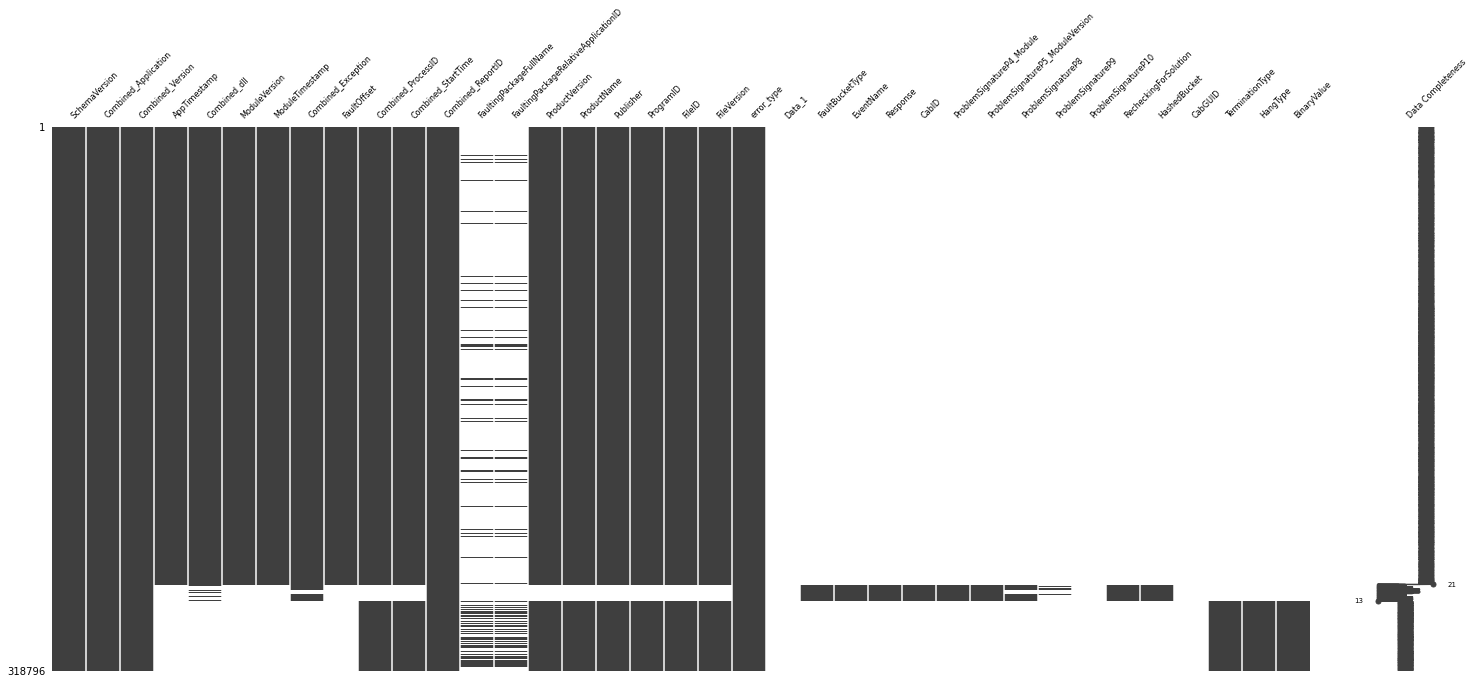

In [16]:
msno.matrix(events.iloc[:, 20:], labels=True, fontsize=8)

In [17]:
# Investigate individual columns' data to see if some can be combined.
events['Combined_Application'].dropna().sample(10)

6397                                         explorer.exe
6503                                          Acrobat.exe
6654                                        SearchApp.exe
3106                                             AWCC.exe
8315                                       PBIDesktop.exe
876                                         g2mupdate.exe
5602    Microsoft.Management.Services.IntuneWindowsAge...
7744                                          conhost.exe
8064                                    RuntimeBroker.exe
1158                                     ScreenSketch.exe
Name: Combined_Application, dtype: object


# Join Machine data with Events data.


In [18]:
machines = pd.read_parquet('../do_not_commit/Datasets/Persist_System_DISC.pq')

<AxesSubplot:>

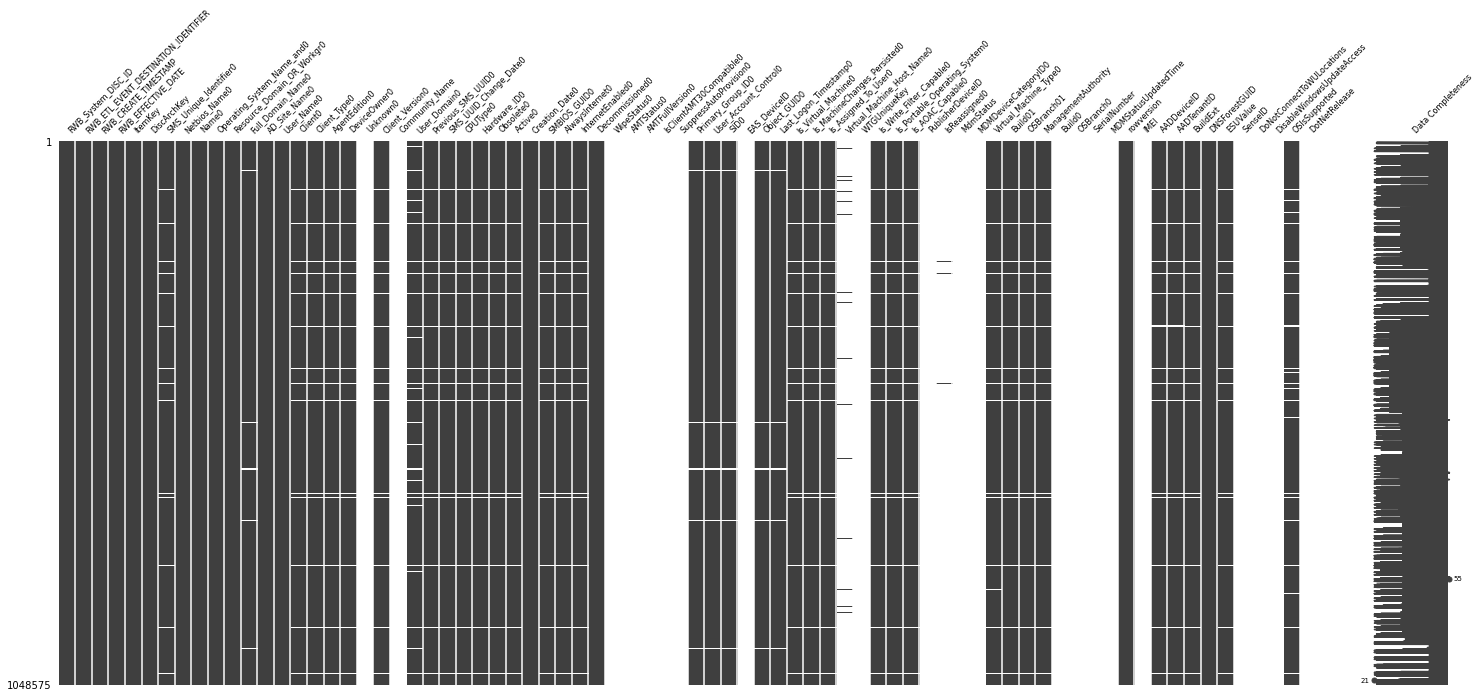

In [19]:
msno.matrix(machines, labels=True, fontsize=8)

In [4]:
# From blob storage:
# incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_INC_20230730.csv', low_memory=False)

<AxesSubplot:>

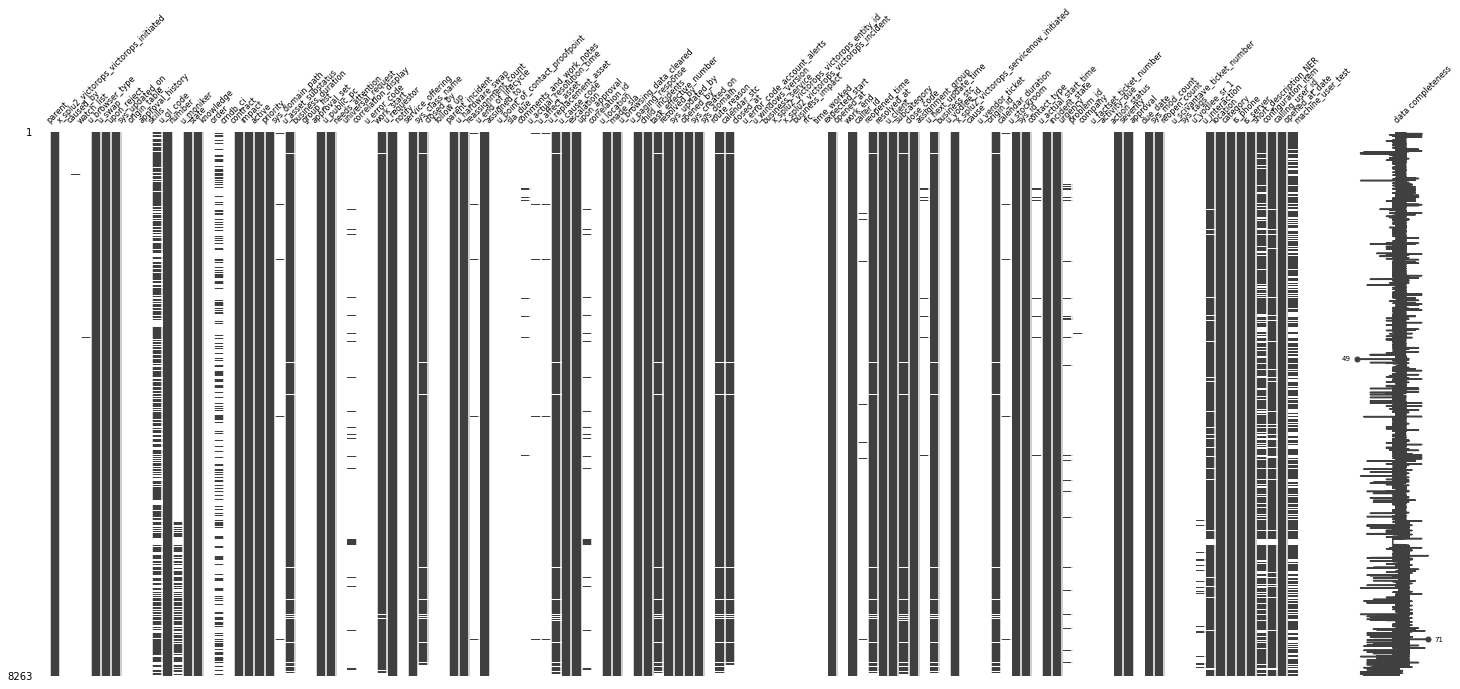

In [21]:
msno.matrix(incs, labels=True, fontsize=8)

In [22]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [23]:
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])

In [24]:
machines_events.sample(5)

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,ProviderName,ProviderGUID,EventID,EventIDQualifiers,...,ProblemSignatureP8,ProblemSignatureP9,ProblemSignatureP10,RecheckingForSolution,HashedBucket,CabGUID,TerminationType,HangType,BinaryValue,Name0
203087,5870500,6725,2023-04-29 08:46:16 -05:00,2023-04-29,72057594085776175,16810421,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-L-U32639
27262,4246671,4741,2023-03-28 08:46:21 -05:00,2023-03-28,72057594084134597,16809191,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIT-L-U32035
153862,634028,836,2023-01-14 09:09:40 -06:00,2023-01-14,72057594080463952,16813647,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-L-U33857
172784,6974255,8027,2023-05-20 08:46:18 -05:00,2023-05-20,72057594086888203,16809286,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,NaN,NaN,NaN,62,Unknown,55006E006B006E006F0077006E0000000000,DAL-L-U32265
177496,6856847,7903,2023-05-18 08:46:22 -05:00,2023-05-18,72057594086770074,16808748,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSH-L-U31465


<AxesSubplot:>

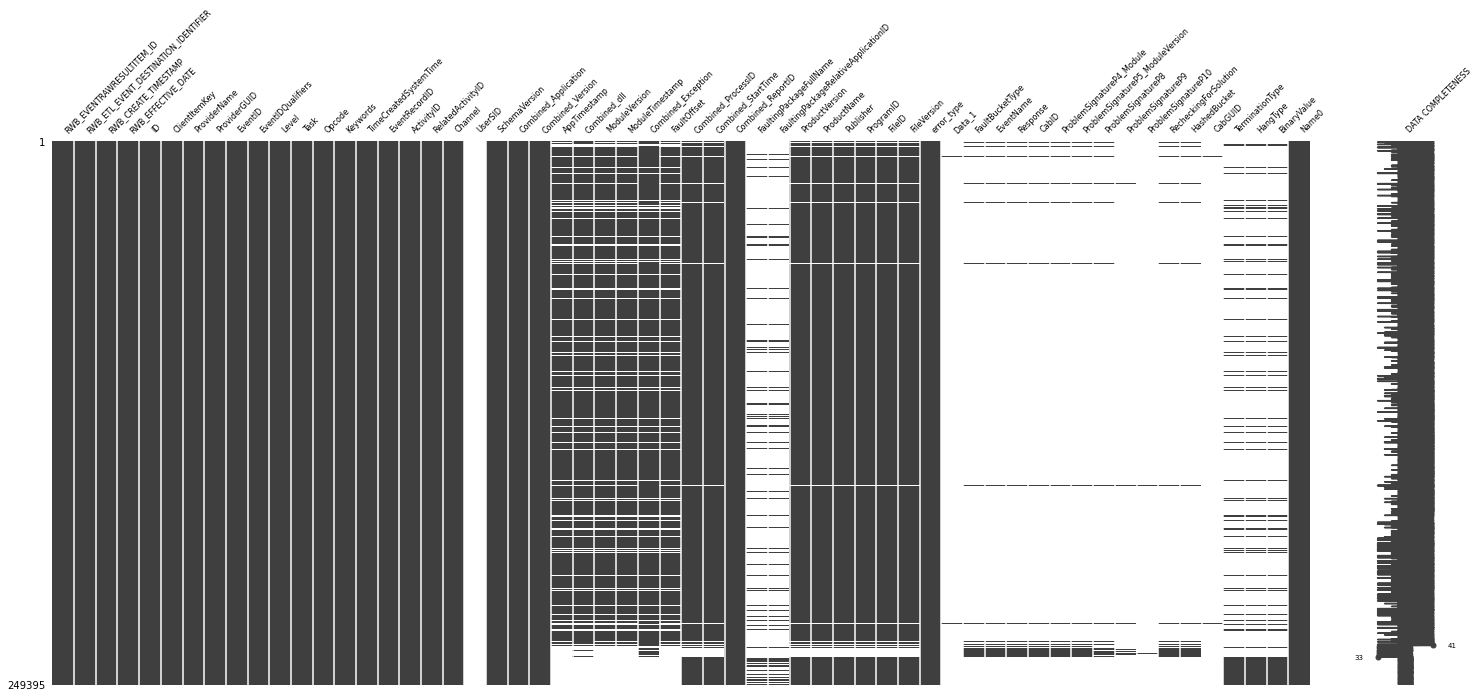

In [25]:
msno.matrix(machines_events, labels=True, fontsize=8)

<AxesSubplot:>

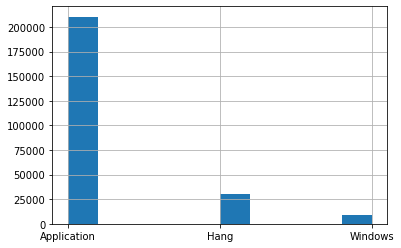

In [26]:
machines_events.sort_values(by=['error_type'])['error_type'].hist()


# Shift TimeCreatedSystemTime to Central time to match INCs.


In [27]:
# Get all TimeCreatedSystemTime values in Central time.
# Use this to map UTC TimeCreatedSystemTime back to the local time.
df_comp = pd.read_parquet('../do_not_commit/Datasets/Persist_Computer_System_DATA.pq')
# Use this to convert local tz to Central given the timezone assigned to a machine.
df_zone = pd.read_parquet('../do_not_commit/Datasets/Persist_Time_Zone_DATA.pq')

In [28]:
machines_events

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,ProviderName,ProviderGUID,EventID,EventIDQualifiers,...,ProblemSignatureP8,ProblemSignatureP9,ProblemSignatureP10,RecheckingForSolution,HashedBucket,CabGUID,TerminationType,HangType,BinaryValue,Name0
0,4949237,5671,2023-04-12 08:46:15 -05:00,2023-04-12,72057594084844452,16803375,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NSV-L-U30084
1,4949238,5671,2023-04-12 08:46:15 -05:00,2023-04-12,72057594084844453,16803375,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NSV-L-U30084
2,4949259,5671,2023-04-12 08:46:15 -05:00,2023-04-12,72057594084844474,16815020,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BWG-L-U33707
3,4949282,5671,2023-04-12 08:46:15 -05:00,2023-04-12,72057594084844497,16790376,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-D-U14178
4,4949283,5671,2023-04-12 08:46:15 -05:00,2023-04-12,72057594084844498,16790376,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-D-U14178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249390,5056473,5733,2023-04-13 08:46:22 -05:00,2023-04-13,72057594084952902,16809755,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,NaN,NaN,NaN,4294967295,Activation,410063007400690076006100740069006F006E0000000000,LOE-L-U32447
249391,5056704,5733,2023-04-13 08:46:22 -05:00,2023-04-13,72057594084953133,16807601,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,NaN,NaN,NaN,4294967295,Quiesce,510075006900650073006300650000000000,MIT-L-U30258
249392,5056707,5733,2023-04-13 08:46:22 -05:00,2023-04-13,72057594084953136,16807601,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,NaN,NaN,NaN,4294967295,Quiesce,510075006900650073006300650000000000,MIT-L-U30258
249393,5057424,5733,2023-04-13 08:46:22 -05:00,2023-04-13,72057594084953853,16804579,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,NaN,NaN,NaN,4294967295,Quiesce,510075006900650073006300650000000000,MIL-L-U30343


In [ ]:
machines_events.merge(df_comp[['Name00', 'CurrentTimeZone00']], left_on=['Name0'], right_on=['Name00'], how='left')

In [ ]:
# Push TimeSystemCreatedTime back to local time by adding 'CurrentTimeZone00'.
machines_events['LocalTime'] = machines_events['TimeCreatedSystemTime'] - machines_events['CurrentTimeZone00']

In [ ]:
# LEFT JOIN computer timezone to machines_events.

In [ ]:
import pytz

# Convert local time values to Central.
def convert_to_cst(df, utc_column_name, cst_column_name):

    # Make sure the UTC column is in datetime format
    df[utc_column_name] = pd.to_datetime(df[utc_column_name])

    # Convert to UTC timezone
    utc_timezone = pytz.timezone('UTC')
    df[utc_column_name] = df[utc_column_name].dt.tz_localize(utc_timezone)

    # Convert to Central Standard Time (CST) timezone
    cst_timezone = pytz.timezone('America/Chicago')
    df[cst_column_name] = df[utc_column_name].dt.tz_convert(cst_timezone)

    # Drop the original UTC column if desired (optional)
    # df.drop(columns=[utc_column_name], inplace=True)

    return df

df_app2 = convert_to_cst(df_app, 'TimeCreatedSystemTime', 'CreatedSystemTime_CST')


# Join Machines data with Boot data.


In [ ]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

In [ ]:
df_boot.rename(
    columns={
        'BootId':'BootID',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'ReportId':'ReportID'
    },
    inplace=True
)

In [ ]:
msno.matrix(df_boot, labels=True, fontsize=8)

In [ ]:
events['Name0'].sample(10)

In [ ]:
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

In [ ]:
df_boot['BootID'] = df_boot['BootID'].dt.strftime('%Y-%m-%d')

In [ ]:
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])

In [ ]:
machines_boot


#### Join INCs to machine + event.


In [ ]:
# TimeCreatedSystemTime is all NaT.
# Use 'GeneratedTime' or 'BootId' instead of 'TimeCreatedSystemTime' for 'Boot' errors?
machines_events[machines_events['error_type'].isin(['Application', 'Hang'])].sample(5)

In [ ]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

In [ ]:
# incs_merged = machines_merged.merge(incs, left_on='Name0', right_on='configuration_item')
incs_merged = machines_events.merge(incs, left_on=['Name0', 'TimeCreatedSystemTimeFormatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [ ]:
print(len(incs_merged))

In [ ]:
# Dropping columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)

In [ ]:
msno.matrix(incs_merged, labels=True, fontsize=7)

In [ ]:
# Issues:
# If a separate error is recorded on the same day as an unrelated INC, the two are associated (.loc[210, :])
# Possible fix: reduce the time window from "same day" to "within x hours," e.g. +/-2hrs.
incs_merged.sample(10)[[
    'error_type',
    # 'OSVersion',
    'Combined_Application',
    'Combined_dll',
    # 'FaultingPackageFullName',
    'ProductName',
    'category',
    'subcategory',
    'short_description_NER'
]]

In [ ]:
incs_merged['number'].unique()

In [ ]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'TimeCreatedSystemTimeFormatted',
    'TimeCreatedSystemTime',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    # 'FaultingApplicationName',
    # 'FaultingModuleName',
    'short_description_NER'
]]


#### Join INCs to machine + boot.


In [ ]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootID'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [ ]:
incs_boot

In [ ]:
# Dropping columns with nothing in them.
incs_boot.dropna(axis=1, how='all', inplace=True)


#### How many multiple INCs were filed on the same day for a given machine?


In [ ]:
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]


# Bring both DataFrames together.


In [ ]:
df = pd.concat([incs_merged, incs_boot])
df.reset_index(inplace=True)

In [ ]:
# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

In [ ]:
df.shape

In [ ]:
msno.matrix(df, labels=True, fontsize=7)

In [ ]:
df.loc[400000, :]

In [ ]:
df['error_type'].hist()

In [ ]:
df[df['error_type'] == 'Boot']


#### How many INCs contain direct reference to BSOD?


In [ ]:
len(df[df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

In [ ]:
df[df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [ ]:
df[(df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'FaultingApplicationName', 'FaultingModuleName', 'ExceptionCode']]

In [ ]:
df[(df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['FaultingApplicationName']

In [ ]:
df[(df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']


#### What is the distribution of FaultApplicationName among INCs?


In [ ]:
df_check = df[df['error_type'] == 'Application']

In [ ]:
df_check['FaultingApplicationName'].value_counts()


#### What is the distribution of modules among INCs?


In [ ]:
df_check['FaultingModuleName'].value_counts()


#### Which exception codes are most common among INCs?


In [ ]:
df_check[['FaultingApplicationName', 'ExceptionCode']].value_counts()